In [1]:
# libraries (copy from p5g)

# import os
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras
import utils
import utils2

import pandas as pd

Using TensorFlow backend.


In [11]:
# simulated data (copy from p5g)
nb_samples = int(10e3) # FIXME # 100e3
lags = [1, 2]
X1 = pd.Series(np.random.randn(nb_samples))
X2 = pd.Series(np.random.randn(nb_samples))
# https://stackoverflow.com/a/20410720/4126114
X_model = pd.concat({'main': X1, 'lagged 1': X1.shift(lags[0]), 'lagged 2': X1.shift(lags[1]), 'new': X2}, axis=1).dropna()
                     
X_model['mult'] = X_model.apply(lambda row: row[2]*row[3], axis=1)

X_model.head()

,lagged 1,lagged 2,main,new,mult
2,0.498943,-0.917198,0.481912,-0.004657,-0.002244
3,0.481912,0.498943,-1.140024,-1.512420,1.724196
4,-1.140024,0.481912,0.530458,-1.023342,-0.542840
5,0.530458,-1.140024,0.726084,-0.482997,-0.350697
6,0.726084,0.530458,1.475789,0.154812,0.228469


X (9998, 5)


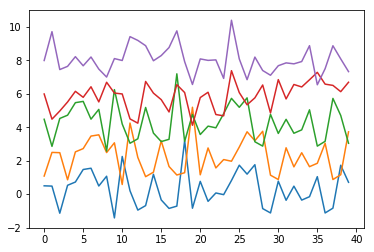

In [12]:
print('X', X_model.shape)
utils.myPlot(X_model.values[:40,:],2)

In [3]:
# Y = X_model.apply(lambda row: 0.25*row[0] + 0.25*row[1] + 0.25*row[2] + 0.25*row[3], axis=1)

Y = X_model.apply(lambda row: 0.2*row['main'] + 0.2*row['lagged 1'] + 0.2*row['lagged 2'] + 0.2*row['new'] + 0.2*row['mult'], axis=1)
Y = Y.reshape((Y.shape[0],1))

# drop columns in X_model that LSTM is supposed to figure out
del X_model['lagged 1']
del X_model['lagged 2']
del X_model['mult']

/home/shadi/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [4]:
X_model.head()

,main,new
2,0.564671,0.514643
3,-0.427911,0.179294
4,1.457073,1.159065
5,1.387692,0.995367
6,-0.495592,0.658841


X (9998, 2) Y (9998, 1)


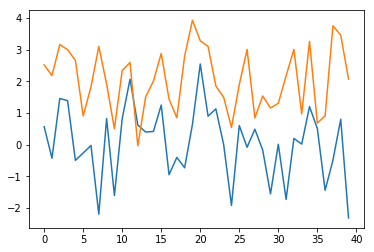

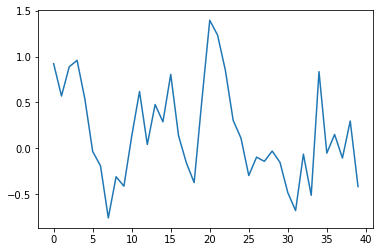

In [5]:
print('X', X_model.shape, 'Y', Y.shape)
utils.myPlot(X_model.values[:40,:],2)
utils.myPlot(Y[:40,],2)

In [6]:
# copy from utils3.py

# stride the data
from skimage.util.shape import view_as_windows # pip install scikit-image
def _load_data_strides(A, n_prev):
    out = view_as_windows(A,window_shape=(n_prev,A.shape[1]),step=1)
    out = out.reshape((out.shape[0],out.shape[2],out.shape[3])) # for some reason need to drop extra dim=1
    return out

look_back = 5
if look_back < max(lags):
    raise Exception("Not enough look back provided")
X_calib = _load_data_strides(X_model.values, look_back)
X_calib.shape

/home/shadi/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


(9994, 5, 2)

In [7]:
Y_calib = Y[(look_back-1):]
Y_calib.shape

(9994, 1)

In [8]:
# copy from g2-ml/take2/ex5-lstm/p4c4.ipynb
from keras.models import load_model
from shutil import copyfile
from datetime import datetime
model = None

from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Dense

print("create brand new")
optimizer='adam'

model = Sequential()
in_neurons = X_model.shape[1]
lstm_dim = 130
model.add(LSTM(lstm_dim, return_sequences=True, input_shape=(None, in_neurons), activation='tanh', dropout=0.25))
enc_dim = 100
model.add(LSTM(enc_dim, return_sequences=False, activation='tanh'))
out_neurons = 1
model.add(Dense(out_neurons, activation='linear'))

model.compile(loss="mean_squared_error", optimizer=optimizer) # nadam

model.summary()

create brand new
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 130)         69160     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               92400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 161,661
Trainable params: 161,661
Non-trainable params: 0
_________________________________________________________________


In [9]:
epochs = 300
history = model.fit(
    x=X_calib,
    y=Y_calib,
    epochs = epochs,
    verbose = 2, #2,
    batch_size = 500, # 100
    validation_split = 0.2,
    shuffle=False
)

Train on 7995 samples, validate on 1999 samples
Epoch 1/300
8s - loss: 0.1495 - val_loss: 0.1154
Epoch 2/300
7s - loss: 0.0990 - val_loss: 0.0660
Epoch 3/300
7s - loss: 0.0852 - val_loss: 0.0577
Epoch 4/300
7s - loss: 0.0797 - val_loss: 0.0511
Epoch 5/300
7s - loss: 0.0750 - val_loss: 0.0445
Epoch 6/300
7s - loss: 0.0696 - val_loss: 0.0402
Epoch 7/300
6s - loss: 0.0682 - val_loss: 0.0362
Epoch 8/300
6s - loss: 0.0614 - val_loss: 0.0297
Epoch 9/300
7s - loss: 0.0498 - val_loss: 0.0209
Epoch 10/300
6s - loss: 0.0394 - val_loss: 0.0170
Epoch 11/300
6s - loss: 0.0330 - val_loss: 0.0179
Epoch 12/300
6s - loss: 0.0313 - val_loss: 0.0118
Epoch 13/300
6s - loss: 0.0299 - val_loss: 0.0134
Epoch 14/300
6s - loss: 0.0274 - val_loss: 0.0101
Epoch 15/300
6s - loss: 0.0259 - val_loss: 0.0085
Epoch 16/300
6s - loss: 0.0256 - val_loss: 0.0072
Epoch 17/300
6s - loss: 0.0239 - val_loss: 0.0062
Epoch 18/300
6s - loss: 0.0236 - val_loss: 0.0065
Epoch 19/300
6s - loss: 0.0222 - val_loss: 0.0052
Epoch 20/30

KeyboardInterrupt: 

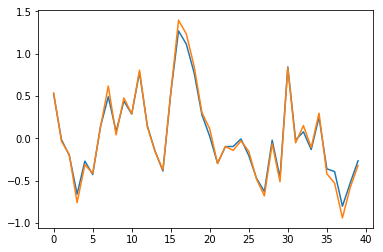

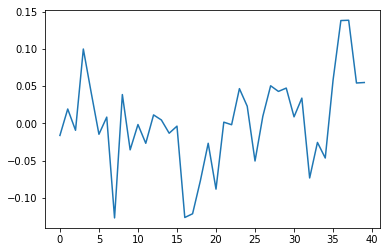

In [10]:
pred = model.predict(x=X_calib, verbose = 0)

from matplotlib import pyplot as plt
plt.plot(pred[:40,])
plt.plot(Y_calib[:40,])
plt.show()

plt.plot(pred[:40,]-Y_calib[:40,])
plt.show()